<a href="https://colab.research.google.com/github/KhangTran139/Summary-News/blob/main/summary_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gowrishankarp/newspaper-text-summarization-cnn-dailymail
!unzip newspaper-text-summarization-cnn-dailymail.zip -d ./cnn_dailymail

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail
License(s): CC0-1.0
 92% 463M/503M [00:00<00:00, 419MB/s]
100% 503M/503M [00:01<00:00, 463MB/s]
Archive:  newspaper-text-summarization-cnn-dailymail.zip
  inflating: ./cnn_dailymail/cnn_dailymail/test.csv  
  inflating: ./cnn_dailymail/cnn_dailymail/train.csv  
  inflating: ./cnn_dailymail/cnn_dailymail/validation.csv  


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# Load dataset
df = pd.read_csv("cnn_dailymail/cnn_dailymail/train.csv")

# Kiểm tra cột
df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [5]:
# Đọc file
train_path = "cnn_dailymail/cnn_dailymail/train.csv"
val_path   = "cnn_dailymail/cnn_dailymail/validation.csv"

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)

# Xem các cột có sẵn
print(df.columns)

# Cột chứa bài báo của tập train
train_df['article_length'] = train_df['article'].apply(lambda x: len(str(x).split()))

# Thống kê độ dài
print("Số lượng bài (train):", len(train_df))
print("Độ dài trung bình (train):", train_df['article_length'].mean())
print("Độ dài lớn nhất (train):", train_df['article_length'].max())
print("Độ dài nhỏ nhất (train):", train_df['article_length'].min())


# Cột chứa bài báo của tập val
val_df['article_length'] = val_df['article'].apply(lambda x: len(str(x).split()))

# Thống kê độ dài
print("Số lượng bài (val):", len(val_df))
print("Độ dài trung bình (val):", val_df['article_length'].mean())
print("Độ dài lớn nhất (val):", val_df['article_length'].max())
print("Độ dài nhỏ nhất (val):", val_df['article_length'].min())

Index(['id', 'article', 'highlights'], dtype='object')
Số lượng bài (train): 287113
Độ dài trung bình (train): 691.8694938926485
Độ dài lớn nhất (train): 2347
Độ dài nhỏ nhất (train): 8
Số lượng bài (val): 13368
Độ dài trung bình (val): 676.0264063435069
Độ dài lớn nhất (val): 1917
Độ dài nhỏ nhất (val): 41


In [6]:
import re

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Các cột:", train_df.columns.tolist())

# Làm sạch văn bản
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\([^)]*\)', '', text)      # bỏ nội dung trong ngoặc
    text = re.sub('"', '', text)
    text = re.sub(r"'s\b", "", text)           # bỏ "'s"
    text = re.sub("[^a-zA-Z]", " ", text)      # bỏ ký tự không phải chữ cái
    text = re.sub('[m]{2,}', 'mm', text)
    text = re.sub(' +', ' ', text)             # bỏ khoảng trắng thừa
    return text.strip()

for df in [train_df, val_df]:
    df['clean_article'] = df['article'].apply(clean_text)
    df['clean_highlights'] = df['highlights'].apply(clean_text)

# Loại bỏ bài quá ngắn
for df_name, df in [('train', train_df), ('val', val_df)]:
    before = df.shape[0]
    df = df[df['clean_article'].apply(lambda x: len(x.split())) > 30]
    df = df[df['clean_highlights'].apply(lambda x: len(x.split())) > 5]
    after = df.shape[0]
    print(f"{df_name}: giữ lại {after}/{before} mẫu sau khi lọc")

# Lưu lại file đã xử lý
train_df.to_csv("cnn_dailymail/cnn_dailymail/train_clean.csv", index=False)
val_df.to_csv("cnn_dailymail/cnn_dailymail/val_clean.csv", index=False)

print(" Hoàn tất tiền xử lý dữ liệu!")

Train: (287113, 4)
Validation: (13368, 4)
Các cột: ['id', 'article', 'highlights', 'article_length']
train: giữ lại 287093/287113 mẫu sau khi lọc
val: giữ lại 13368/13368 mẫu sau khi lọc
 Hoàn tất tiền xử lý dữ liệu!


In [7]:
# Tokenization và padding

# Tách dữ liệu đầu vào và đầu ra
x_train = train_df['clean_article']
y_train = train_df['clean_highlights']

x_val = val_df['clean_article']
y_val = val_df['clean_highlights']

y_train = y_train.apply(lambda x: 'sostok ' + x + ' eostok')
y_val = y_val.apply(lambda x: 'sostok ' + x + ' eostok')

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

max_text_len = 250
max_summary_len = 50

x_train_seq = pad_sequences(x_tokenizer.texts_to_sequences(x_train), maxlen=max_text_len, padding='post')
y_train_seq = pad_sequences(y_tokenizer.texts_to_sequences(y_train), maxlen=max_summary_len, padding='post')

x_val_seq = pad_sequences(x_tokenizer.texts_to_sequences(x_val), maxlen=max_text_len, padding='post')
y_val_seq = pad_sequences(y_tokenizer.texts_to_sequences(y_val), maxlen=max_summary_len, padding='post')

vocab_x = len(x_tokenizer.word_index) + 1
vocab_y = len(y_tokenizer.word_index) + 1

print(f"Vocabulary Size (X): {vocab_x}, (Y): {vocab_y}")

Vocabulary Size (X): 439231, (Y): 147293


In [9]:
# Xây dựng mô hình

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

latent_dim = 300  # Số chiều ẩn trong LSTM

# Encoder
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(vocab_x, latent_dim, trainable=True)(encoder_inputs)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(enc_emb)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_y, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention
attention = Attention()([decoder_output, encoder_output])
decoder_concat = Concatenate(axis=-1)([decoder_output, attention])

# Dense output
decoder_dense = Dense(vocab_y, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# Compile model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 250, 300)  │ 131,769,3… │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 300) │ 44,187,900 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 250,      │    721,200 │ embedding_2[0][0] │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    721,200 │ embedding_3[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, None, 300) │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 600) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None,      │ 88,523,093 │ concatenate_1[0]… │
│                     │ 147293)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 265,922,693 (1014.41 MB)

 Trainable params: 265,922,693 (1014.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Mô hình
from tensorflow.keras.callbacks import EarlyStopping

# Callback dừng sớm
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,          # độ chênh nhỏ nhất để cải thiện
    patience=5,              # dừng nếu 5 epoch liên tiếp không giảm val_loss
    verbose=1,
    restore_best_weights=True
)

# Huấn luyện mô hình
history = model.fit(
    [x_train_seq, y_train_seq[:, :-1]],  # input: article + highlights không có token cuối
    y_train_seq[:, 1:].reshape(y_train_seq.shape[0], y_train_seq.shape[1]-1, 1),  # output: highlights dịch phải 1 bước
    epochs=10,
    batch_size=32,
    validation_data=(
        [x_val_seq, y_val_seq[:, :-1]],
        y_val_seq[:, 1:].reshape(y_val_seq.shape[0], y_val_seq.shape[1]-1, 1)
    ),
    callbacks=[earlystopping],  # thêm callback vào đây
    shuffle=True
)

Epoch 1/10
8973/8973 ━━━━━━━━━━━━━━━━━━━━ 1128s 125ms/step - loss: 7.0723 - val_loss: 6.4252
Epoch 2/10
8973/8973 ━━━━━━━━━━━━━━━━━━━━ 1125s 125ms/step - loss: 6.1779 - val_loss: 6.2379
Epoch 3/10
8973/8973 ━━━━━━━━━━━━━━━━━━━━ 1127s 126ms/step - loss: 6.0396 - val_loss: 6.1626
Epoch 4/10
8973/8973 ━━━━━━━━━━━━━━━━━━━━ 1126s 126ms/step - loss: 5.9781 - val_loss: 6.1195
Epoch 5/10
8973/8973 ━━━━━━━━━━━━━━━━━━━━ 1162s 125ms/step - loss: 5.9416 - val_loss: 6.0806
Epoch 6/10
8973/8973 ━━━━━━━━━━━━━━━━━━━━ 1127s 126ms/step - loss: 5.9123 - val_loss: 6.0458
Epoch 7/10
8973/8973 ━━━━━━━━━━━━━━━━━━━━ 1126s 126ms/step - loss: 5.8749 - val_loss: 5.9888
Epoch 8/10
8973/8973 ━━━━━━━━━━━━━━━━━━━━ 1125s 125ms/step - loss: 5.8395 - val_loss: 5.9559
Epoch 9/10
8973/8973 ━━━━━━━━━━━━━━━━━━━━ 1124s 125ms/step - loss: 5.8148 - val_loss: 5.9275
Epoch 10/10
8973/8973 ━━━━━━━━━━━━━━━━━━━━ 1125s 125ms/step - loss: 5.7860 - val_loss: 5.8931
Restoring model weights from the end of the best epoch: 10.


In [ ]:
# Tải model xuống
model.save("caption_model.h5")
from google.colab import files
files.download("caption_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Tải model lên
from google.colab import files
uploaded = files.upload()

from tensorflow.keras.models import load_model
model = load_model("caption_model.h5")

Saving caption_model.h5 to caption_model.h5


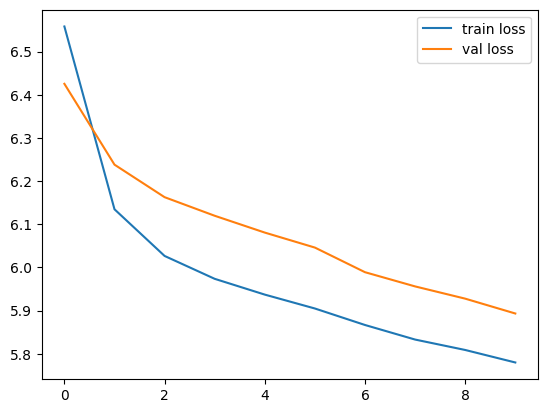

In [ ]:
# Đánh giá mô hình
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# Đọc dữ liệu tập test
import re

test_df = pd.read_csv("cnn_dailymail/cnn_dailymail/test.csv")
print(test_df.head())

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub('"', '', text)
    text = re.sub(r"'s\b", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub('[m]{2,}', 'mm', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

test_df['clean_article'] = test_df['article'].apply(clean_text)

x_test = test_df['clean_article']

x_test_seq = x_tokenizer.texts_to_sequences(x_test)
x_test_seq = tf.keras.preprocessing.sequence.pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')

                                         id  \
0  92c514c913c0bdfe25341af9fd72b29db544099b   
1  2003841c7dc0e7c5b1a248f9cd536d727f27a45a   
2  91b7d2311527f5c2b63a65ca98d21d9c92485149   
3  caabf9cbdf96eb1410295a673e953d304391bfbb   
4  3da746a7d9afcaa659088c8366ef6347fe6b53ea   

                                             article  \
0  Ever noticed how plane seats appear to be gett...   
1  A drunk teenage boy had to be rescued by secur...   
2  Dougie Freedman is on the verge of agreeing a ...   
3  Liverpool target Neto is also wanted by PSG an...   
4  Bruce Jenner will break his silence in a two-h...   

                                          highlights  
0  Experts question if  packed out planes are put...  
1  Drunk teenage boy climbed into lion enclosure ...  
2  Nottingham Forest are close to extending Dougi...  
3  Fiorentina goalkeeper Neto has been linked wit...  
4  Tell-all interview with the reality TV star, 6...  


In [ ]:
# Tạo mô hình suy luận

# Encoder model
encoder_model = model(encoder_inputs, [encoder_output, state_h, state_c])

# Decoder model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))  # encoder_output
dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_output2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)
attention2 = Attention()([decoder_output2, decoder_hidden_state_input])
decoder_concat2 = Concatenate(axis=-1)([decoder_output2, attention2])
decoder_outputs2 = decoder_dense(decoder_concat2)
decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2]
)

In [ ]:
# Tạo ra bản tóm tắt mới
reverse_target_index = y_tokenizer.index_word
target_index = y_tokenizer.word_index

def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((1,1))
    target_seq[0,0] = target_index['sos']

    decoded_sentence = ""
    stop = False

    while not stop:
        output, h, c = decoder_model.predict([target_seq, e_out, e_h, e_c], verbose=0)
        word_idx = np.argmax(output[0, -1, :])
        word = reverse_target_index.get(word_idx, '')

        if word == 'eos' or len(decoded_sentence.split()) >= max_summary_len:
            stop = True
        else:
            decoded_sentence += ' ' + word

        target_seq = np.zeros((1,1))
        target_seq[0,0] = word_idx
        e_h, e_c = h, c

    return decoded_sentence.strip()

In [ ]:
# Test mô hình
import random

idx = random.randint(0, len(test_df)-1)
print("\n Bài báo mẫu:", idx)

article = test_df['article'].iloc[idx]
pred_highlights = decode_sequence(x_test_seq[idx].reshape(1, max_text_len))
actual_highlights = test_df['highlights'].iloc[idx]

print("\n Bài báo:")
print(article)
print(f"Độ dài : {len(article.split())}")

print("\n Máy tóm tắt:")
print(pred_highlights)
print(f"Độ dài: {len(pred_highlights.split())}")

print("\n Bài tóm tắt thật:")
print(actual_highlights)
print(f"Độ dài: {len(actual_highlights.split())}")


 Bài báo mẫu: 6653
